In [51]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
import ast
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol, order_value
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
bundle = 'snp500'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [3]:
data = pd.read_csv('price_by_prphet_etna.csv',index_col=0)
data

,AAPL,AMZN,GOOGL,MSFT,TSLA
timestamp,,,,,
2018-04-11,41.732859,69.573391,49.740199,89.893124,18.299433
2018-04-12,41.834317,68.910907,49.711924,89.785710,18.317717
2018-04-13,41.826657,69.408024,50.512207,90.265297,18.474969
2018-04-14,42.127574,68.772377,50.124684,90.347347,18.549962
2018-04-15,42.304194,68.778095,50.571658,90.383293,18.611702
...,...,...,...,...,...
2023-06-25,167.402489,107.266698,109.960276,311.677923,146.834335
2023-06-26,168.296920,106.943940,110.919265,313.019501,148.143752
2023-06-27,169.274921,107.908689,112.024663,312.477668,150.399746


In [4]:
returns = data.pct_change()
returns=returns[1:]

In [5]:
returns.index=pd.to_datetime(returns.index)

In [49]:
returns

,AAPL,AMZN,GOOGL,MSFT,TSLA
timestamp,,,,,
2018-04-12,0.002431,-0.009522,-0.000568,-0.001195,0.000999
2018-04-13,-0.000183,0.007214,0.016098,0.005341,0.008585
2018-04-14,0.007194,-0.009158,-0.007672,0.000909,0.004059
2018-04-15,0.004193,0.000083,0.008917,0.000398,0.003328
2018-04-16,0.000910,0.003210,-0.012144,0.004103,-0.003315
...,...,...,...,...,...
2023-06-25,-0.001069,0.002331,-0.007392,0.005821,0.006495
2023-06-26,0.005343,-0.003009,0.008721,0.004304,0.008918
2023-06-27,0.005811,0.009021,0.009966,-0.001731,0.015228


In [58]:
def initialize(context):
     # Load the returns dataframe
    context.returns = returns

    # Define the assets (column names) to trade
    context.assets = context.returns.columns.tolist()

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'

 
def handle_data(context, data):
    for asset in context.assets:
        today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
        print (today_return)

        # Buy if return is positive, sell if negative
        if today_return > 0:
            order_value(symbol(asset), 1000)
            print('buy', asset)
        else:
            order_value(symbol(asset), -1000)
            print('sell', asset)

In [62]:
def initialize(context):
     # Load the returns dataframe
    context.returns = returns

    # Define the assets (column names) to trade
    context.assets = context.returns.columns.tolist()

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    context.take_profit_long, context.take_profit_short  = 0.04, 0.04
    context.stop_loss_long, context.stop_loss_short = 0.03, 0.03
 
def handle_data(context, data):
    for asset in context.assets:
        today_return = context.returns.loc[context.get_datetime().strftime('%Y-%m-%d'), asset]
       

        # Buy if return is positive, sell if negative
        if today_return > 0:
            order_value(symbol(asset), 1000)
            print('buy', asset)
        else:
            order_value(symbol(asset), -1000)
            print('sell', asset)
    for asset in context.portfolio.positions:
            current_price = data.current(asset, 'price')
            cost_basis = context.portfolio.positions[asset].cost_basis
            amount = context.portfolio.positions[asset].amount
            if amount > 0:
                if current_price >= cost_basis * (1 + context.take_profit_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis * (1 - context.stop_loss_long):
                    order_target_percent(asset, 0)
                    print('stoploss')
            elif amount < 0:
                if current_price >= cost_basis * (1 + context.stop_loss_short):
                    order_target_percent(asset, 0)
                    print('stoploss')
                elif current_price <= cost_basis *  (1 - context.take_profit_short):
                    order_target_percent(asset, 0)
                    print('stoploss')

In [63]:
start = '2018-04-13'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

sell AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
buy AAPL
buy AMZN
sell GOOGL
buy MSFT
sell TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
sell TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
sell TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
stoploss
buy AAPL
buy AMZN
sell GOOGL
buy MSFT
sell TSLA
sell AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
stoploss
stoploss
sell AAPL
buy AMZN
buy GOOGL
sell MSFT
buy TSLA
stoploss
sell AAPL
sell AMZN
sell GOOGL
sell MSFT
sell TSLA
sell AAPL
buy AMZN
buy GOOGL
sell MSFT
sell TSLA
stoploss
sell AAPL
buy AMZN
sell GOOGL
buy MSFT
sell TSLA
sell AAPL
buy AMZN
sell GOOGL
sell MSFT
buy TSLA
sell AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
stoploss
buy AAPL
buy AMZN
sell GOOGL
sell MSFT
buy TSLA
stoploss
sell AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
sell AAPL
buy AMZN
sell GOOGL
buy MSFT
sell TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
buy AAPL
buy AMZN
buy GOOGL
buy MSFT
buy TSLA
buy AAPL
buy AMZN
buy GOOGL
buy 

<AxesSubplot:>

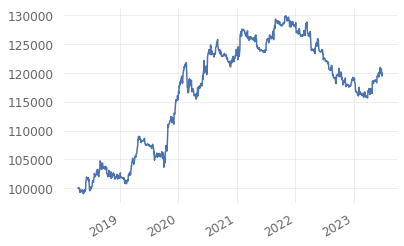

In [64]:
results.portfolio_value.plot()

<AxesSubplot:>

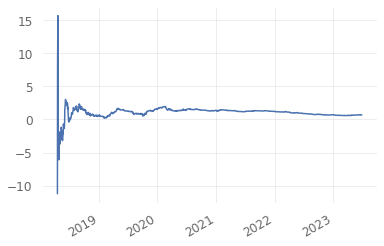

In [55]:
results.sharpe.plot()

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-16   2018-04-16
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             67.0%        100.0%

Cumulative Return          64.18%       19.97%
CAGR﹪                     6.8%         2.45%

Sharpe                     0.56         0.68
Prob. Sharpe Ratio         90.61%       94.08%
Smart Sharpe               0.56         0.68
Sortino                    0.84         1.01
Smart Sortino              0.83         1.0
Sortino/√2                 0.59         0.71
Smart Sortino/√2           0.59         0.71
Omega                      1.14         1.14

Max Drawdown               -27.32%      -11.0%
Longest DD Days            472          604
Volatility (ann.)          20.63%       5.33%
R^2                        0.0          0.0
Information Ratio          -0.02        -0.02
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-02,2023-03-28,2023-06-28,604,-10.999447,-10.857674
2,2020-02-20,2020-04-21,2020-06-09,110,-5.220414,-4.910164
3,2019-05-06,2019-10-02,2019-10-24,172,-4.901541,-4.244480
4,2018-08-31,2019-02-11,2019-03-18,200,-3.800467,-3.702012
5,2020-09-03,2020-11-23,2021-01-19,139,-3.769996,-3.753536


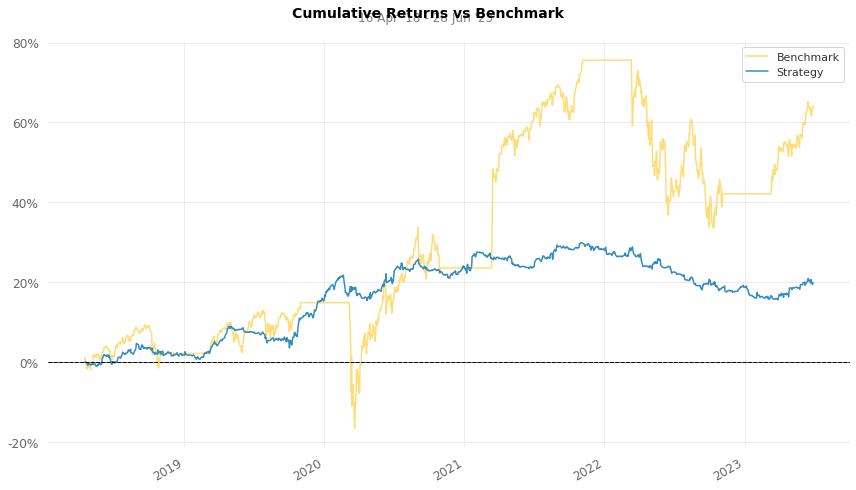

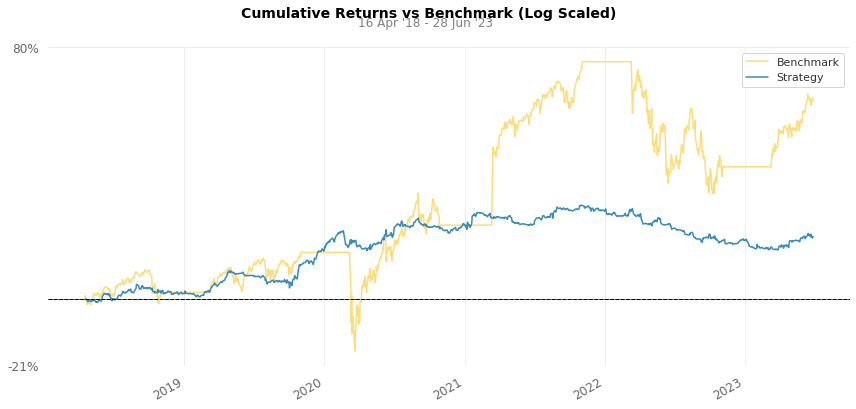

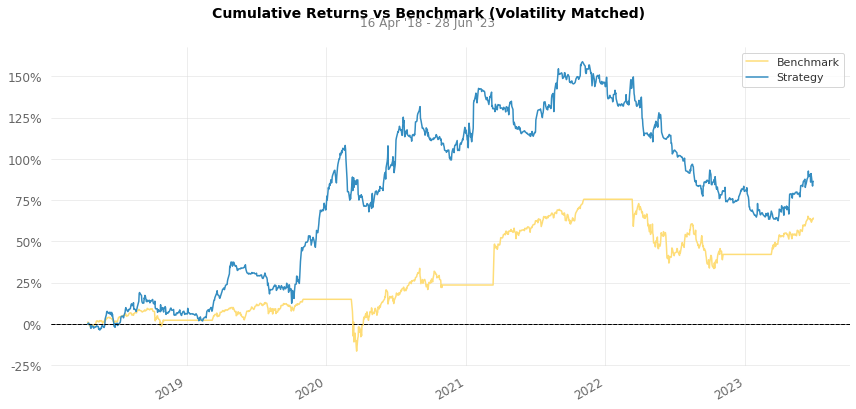

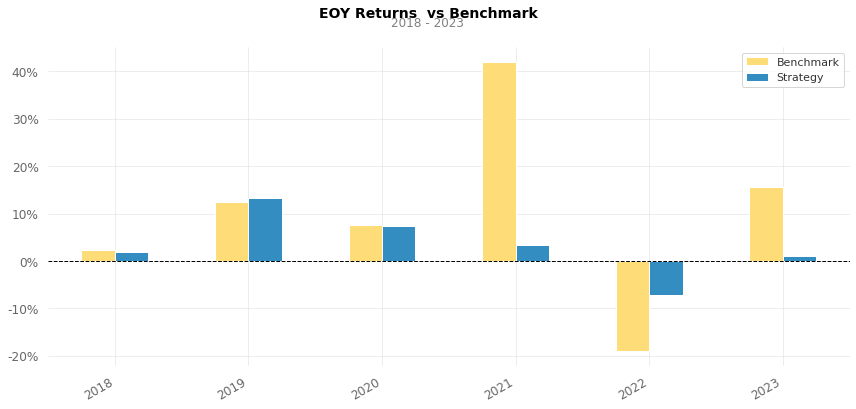

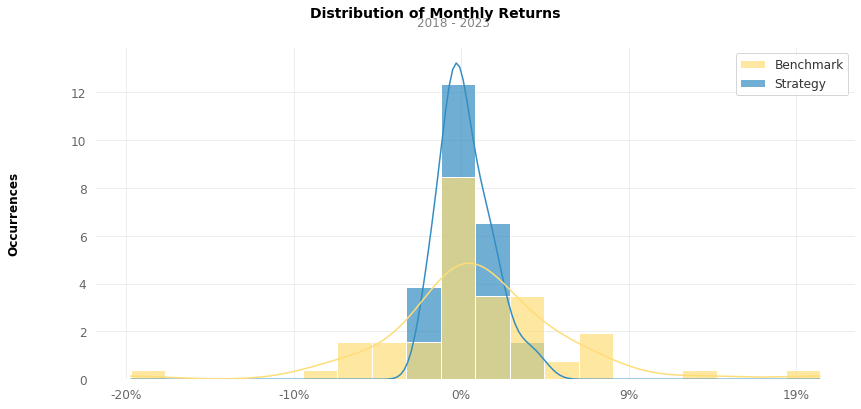

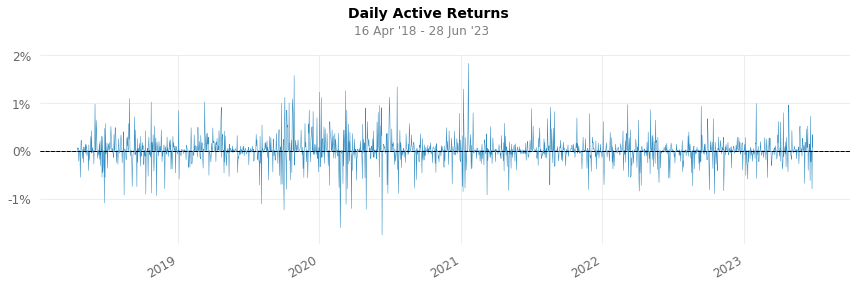

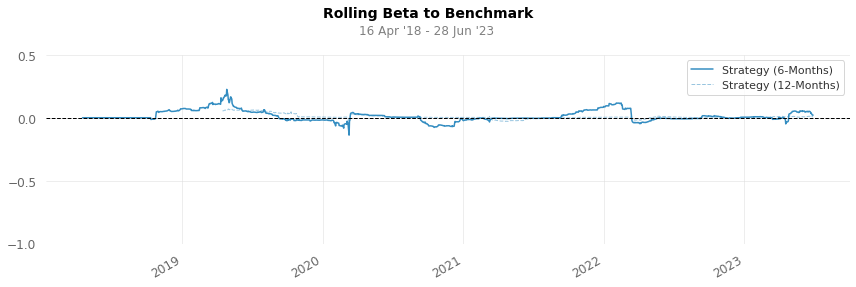

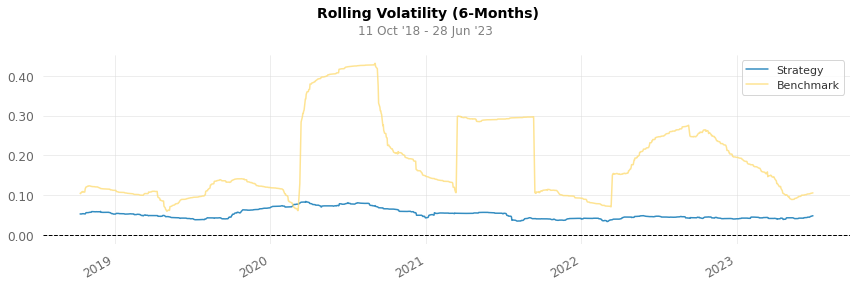

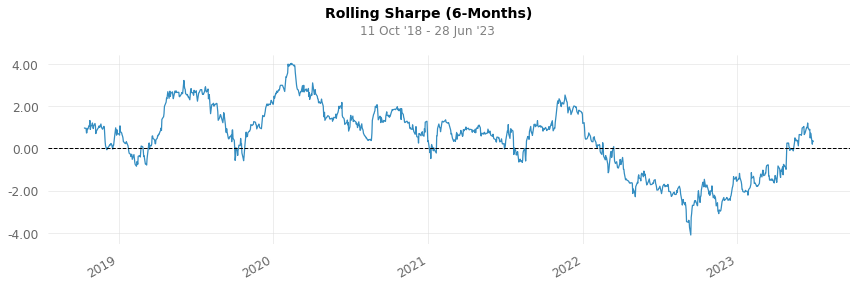

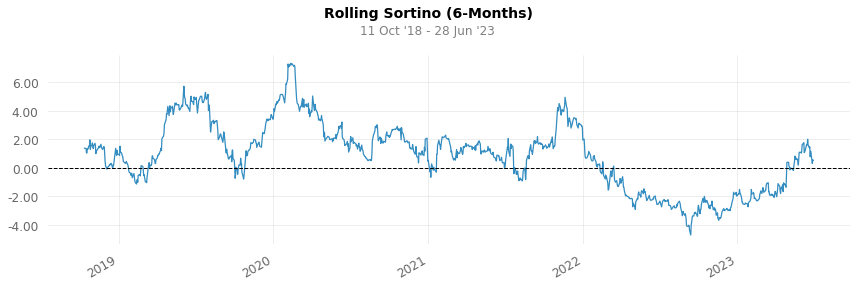

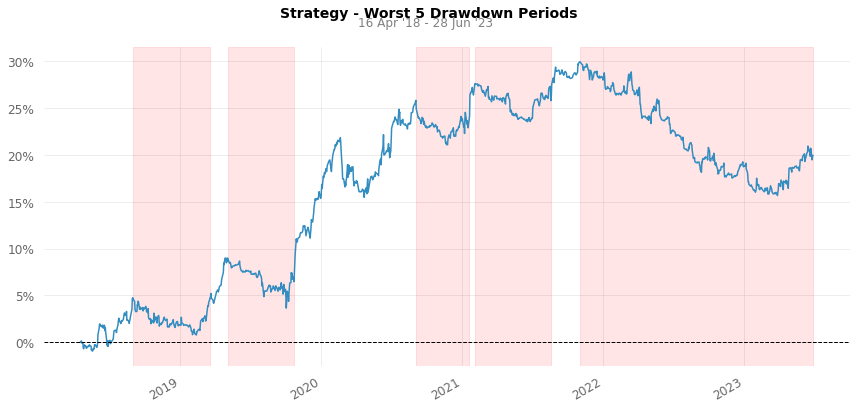

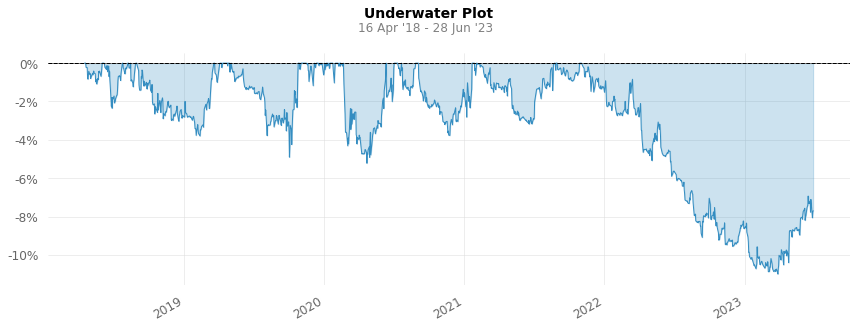

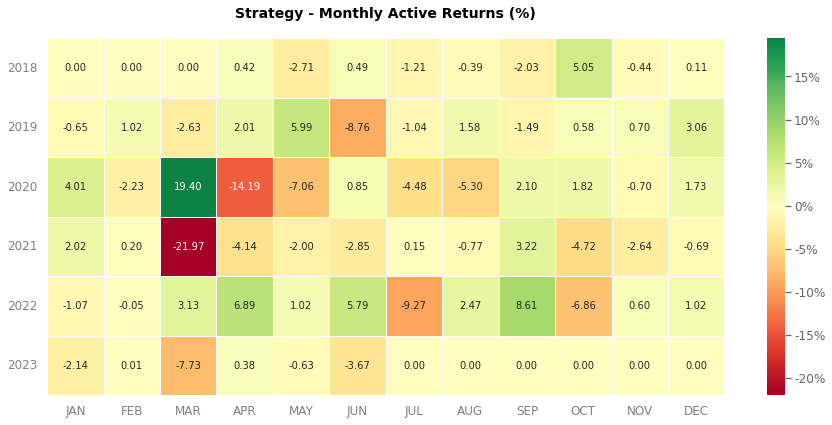

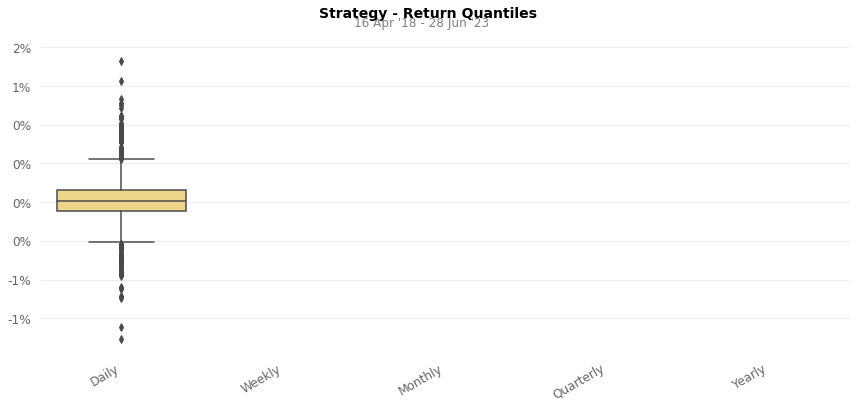

In [65]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6))